# House price prediction using advanced regression techniques
### Kaggle-competition 

Importing libraries. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import Ridge 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings;
warnings.filterwarnings('ignore');

#### Data cleaning  

I start by loading and looking at the train data



In [2]:
hp=pd.read_csv('train.csv')
hp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

There seems to be a few column with many missing values. I decide to plot the columns with more than 10% missing values to get a visual overview.

In [4]:
nullvalues = hp.isnull().sum()/len(hp)*100
nullvalues = nullvalues[nullvalues>10]
nullvalues.sort_values(inplace=True, ascending=False)
nullvalues=nullvalues.to_frame()
nullvalues.columns=['Count']
nullvalues.index.names = ['Column']
nullvalues.reset_index(level=0, inplace=True)
nullvalues

,Column,Count
0,PoolQC,99.520548
1,MiscFeature,96.301370
2,Alley,93.767123
3,Fence,80.753425
4,FireplaceQu,47.260274
5,LotFrontage,17.739726


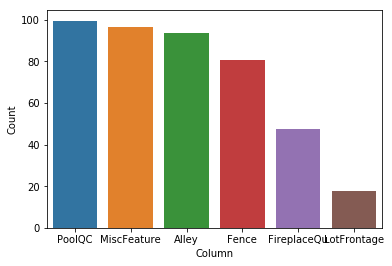

In [5]:
sns.barplot(x='Column', y='Count', data=nullvalues)
plt.show()

Reading the documentation-file I decide to loose the Misc Feature column since there are so many missing values the few features that are  
there are to few to build a model on. 

I decide to take a closer look at the Pool QC column. 

In [6]:
hp['PoolQC'].value_counts()

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

I debate with myself whether to keep the column or to replace the missing values with NP for "No Pool". The actual values 
are very few, and the different "qualities" of the pool are Excellent, Good, Average/Typical and Fair means that even though they are 
different on a scale there is only two entries that have "fair" which is "below average" - and we have the numerical column over pool area where the existance of a pool is documented. I decide to skip that column as well. 

I look at the fireplace columns to see if I can change the missing values in the quality column with "No fireplace". 

In [7]:
hp['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [8]:
hp['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

Seeing that the number of fireplaces and the number of entered values in 'FireplaceQu' are the same I decide to replace all the missing values of "Fireplace Qu" with "N" for "none" as in "no fireplace". 

In [9]:
hp['FireplaceQu'].fillna('N', inplace = True) 

For both the columns "Alley" and "Fence" it is stated that the missing values means no alley acces respectivly no fence. Since the data isn't bigger and the missing value rate is as high as it is in these columns - 93 and close to 80 % - I decide to skip these columns.    
    
I take a closer look at the Lot Frontage column

In [10]:
hp['LotFrontage'].tail(20)

1440    79.0
1441     NaN
1442    85.0
1443     NaN
1444    63.0
1445    70.0
1446     NaN
1447    80.0
1448    70.0
1449    21.0
1450    60.0
1451    78.0
1452    35.0
1453    90.0
1454    62.0
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, dtype: float64

In [11]:
hp[hp['LotFrontage']==0.0].index.tolist()

[]

I decide to keep this column but change the missing values to zero as it is most likley that that is the case since there are no entered values that are 0.0. 

In [12]:
hp['LotFrontage'].fillna(0.0 , inplace = True) 
hp['LotFrontage'].tail(20)

1440    79.0
1441     0.0
1442    85.0
1443     0.0
1444    63.0
1445    70.0
1446     0.0
1447    80.0
1448    70.0
1449    21.0
1450    60.0
1451    78.0
1452    35.0
1453    90.0
1454    62.0
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, dtype: float64

Dropping the columns: Pool QC, Misc Features, Alley, and Fence.

In [13]:
hp.drop(['PoolQC','MiscFeature', 'Alley', 'Fence'],axis=1,inplace=True)

Looking at the reminder of missing values. 

In [14]:
nullvalues = hp.isnull().sum()/len(hp)*100
nullvalues = nullvalues[nullvalues>0]
nullvalues.sort_values(inplace=True, ascending=False)
nullvalues

GarageCond      5.547945
GarageQual      5.547945
GarageFinish    5.547945
GarageYrBlt     5.547945
GarageType      5.547945
BsmtFinType2    2.602740
BsmtExposure    2.602740
BsmtFinType1    2.534247
BsmtCond        2.534247
BsmtQual        2.534247
MasVnrArea      0.547945
MasVnrType      0.547945
Electrical      0.068493
dtype: float64

Tackling this one column at the time. 
The general approach being: 
- if it is an ordinal value I use the value the documentation indicates to replace the missing value, like "No Basement" for example. Or with the MasVnrType there is a value called None. Otherwise I'll use the mode - most occuring value. 
- if it is a numerical value I look at the values to see if a mean, median or zero will be the smarter aproach. 


When it comes to the Garage columns I can see that the missing value ratio is the same in all columns showing that the missing values are actually the indication of having no Garage. I therefore insert a new variable N for "none/no garage" in the categorical columns and drop the "GarageYrBlt" column since it is more important in which condition the garage is in than the year it was built. 

In [15]:
hp.update(hp[['GarageCond','GarageFinish','GarageQual', 'GarageType']].fillna('N'))

In [16]:
hp.drop(['GarageYrBlt'],axis=1,inplace = True)

For Basement columns N is the same as "none/No basement". 

In [17]:
hp.update(hp[['BsmtCond','BsmtExposure','BsmtQual', 'BsmtFinType1', 'BsmtFinType2']].fillna('N'))

In [18]:
hp['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [19]:
hp['MasVnrType']= hp['MasVnrType'].fillna(hp['MasVnrType'].mode()[0])

In [20]:
hp['MasVnrArea'].median()

0.0

In [21]:
hp['MasVnrArea'].mean()

103.68526170798899

I decide to replace the missing value in the 'MasVnrArea' column with the median - that is zero.

In [22]:
hp['MasVnrArea'].fillna(0, inplace = True)

In [23]:
hp['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [24]:
hp['Electrical']= hp['Electrical'].fillna(hp['Electrical'].mode()[0])

Looking at the columns again to see that all columns have 1460 non-null values. 

In [25]:
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

I do notice that I still have the ID column left. I will not need it when I do my prediction scince it is an unique identifier. Therefore I remove it. 

In [26]:
hp.drop(['Id'],axis=1,inplace=True)

The shape is now: 

In [27]:
hp.shape

(1460, 75)

**Categorical values**  

I decide to tackle the categorical columns and start with looking at the ordinal variables and decide to change them to numerical scale.   
  
**Lot shape** has the following categories; *regular, slightly irregular, moderately irregular*, and *irregular*. The numerical scale will be 0-3 where 0 represents *regular*, since the abbriviations of the above mentioned categories are; *Reg, IR1, IR2,* and *IR3*.   

In [28]:
hp['LotShape'] = hp['LotShape'].map({'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3})

**Utilities** has the following categories and abbriviations; *AllPub - All public Utilities (E,G,W,& S), NoSewr - Electricity, Gas, and Water (Septic Tank), NoSeWa - Electricity and Gas Only*, and *ELO - Electricity only*. I set the numerical scale to 4-1, where the number represents the number of utilities (and zero would have been no electricity either). 

In [29]:
hp['Utilities'] = hp['Utilities'].map({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1})

**Land Slope** has the following categories and abbriviations; *Gtl - Gentle slope, Mod - Moderate Slope*, and *Sev - Severe Slope*. I set the numerical scale to 1-3 where 1 is 'Gentle slope' (and 0 would have been 'no slope').

In [30]:
hp['LandSlope'] = hp['LandSlope'].map({'Gtl': 1, 'Mod': 2, 'Sev': 3})

**Exter Cond, Exter Qual, KitchenQual**, and **HeatingQC** have a scale from *Excellent* to *Poor* in five stages, therefor I set the numerical scale to 5-1 (where 5 is excellent and 1 is poor).

In [31]:
n ={'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1} 
hp[['ExterCond','ExterQual','HeatingQC', 'KitchenQual']] = hp[
    ['ExterCond','ExterQual','HeatingQC', 'KitchenQual']].applymap(n.get)

**BsmtQual** and **BsmtCond** have the same scales as "Exter" dito but with the addition of *NB* that I made earlier when dealing with missing values. *N* meaning no basement will therefore be 0, the others will be handled as above. 
The same goes for **FireplaceQu** but with *N* for 'No Fireplace', **GarageQual** and **GarageCond** with *N* for 'No Garage'.

In [32]:
b = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'N': 0}
hp[['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']] = hp[
    ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']].applymap(b.get)

**BsmtExposure** categories and abbriviations: *Gd - Good Exposure, Av - Average Exposure (split levels or foyers typically score average or above), Mn - Mimimum Exposure, No - No Exposure*, and *N - No Basement*. Numerical scale: 3-0 where *Gd* is three and *No* AND *NB* both will be 0 since niehter has any basement exposure.

In [33]:
hp['BsmtExposure'] = hp['BsmtExposure'].map({'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0, 'N':0})

**BsmtFinType 1** and **BsmtFinType 2** categories and abbriviations: *GLQ - Good Living Quarters, ALQ - Average Living Quarters, BLQ - Below Average Living Quarters, Rec - Average Rec Room, LwQ - Low Quality, Unf - Unfinshed*, and *N - No Basement*. Numerical scale: 6-0 where *GLQ* is 6 and *N* is 0.

In [34]:
bt = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'N': 0}
hp[['BsmtFinType1', 'BsmtFinType2']] = hp[['BsmtFinType1', 'BsmtFinType2']].applymap(bt.get)

**Functional** has eight categories ranging from *Typical Functionality* to *Salvage only*,I set the numerical to 0-7 where *Total Functionality* is 0.

In [35]:
hp['Functional'] = hp[
    'Functional'].map({'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7})

**Garage Finish** cat. and ab.: *Fin - Finished, RFn - Rough Finished, Unf - Unfinished*, and *N - No Garage*. Numerical 3-0 where 3 is *Finished*.

In [36]:
hp['GarageFinish'] = hp['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'N': 0})

**PavedDrive** cat. and ab.: *Y - Paved, P - Partial Pavement*, and *N - Dirt/Gravel*. Numerical 2-0 where *Paved* is 2. 

In [37]:
hp['PavedDrive'] = hp['PavedDrive'].map({'Y': 2, 'P': 1, 'N': 0})

**Electrical** is categorised as 'ordinal' but since and for some variables it is true, but there is also a variable called 'mix' which makes it harder to decide a numerical value. I decide to use one-hot-encoding for this column as I will for the columns with nominal values.  
  
**Central Air** is categorised as 'nominal' but the variables are eather yes or no. Istead of creating Dummies for this one I just change every yes to 1 and every no to 0.  

In [38]:
hp['CentralAir'] = hp['CentralAir'].map({'Y': 1, 'N': 0})

##### Outliers  
I need to see if there are any outliers that might hinder my models. 

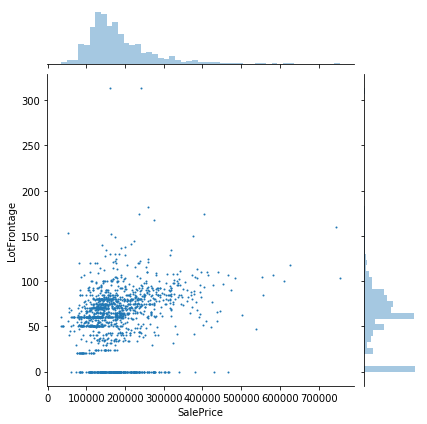

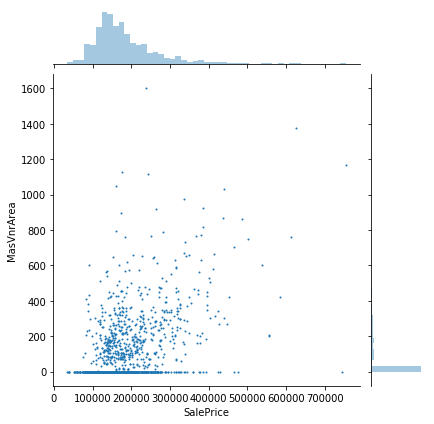

In [39]:
for col in hp.loc[:, hp.dtypes == np.number].keys():
    sns.jointplot(hp['SalePrice'], col, data=hp, height=6, s=1)
plt.show()

It looks like my models will be enhanced if I remove the objects that have a Lot frontage SF over 250 SF. I will also remove the objects with a sales price over 700000.

In [40]:
hp = hp[(hp['LotFrontage'] < 250)  & (hp['SalePrice']<700000)]

In [41]:
hp.shape

(1456, 75)

That was only four rows, but they will make a difference for the preformance of the models - in a good way. 

**Target value**  
Before I start with the test data I take a look at the target value - the Sales price. 

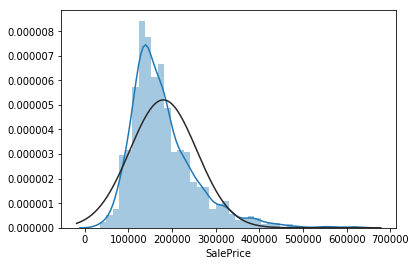

In [42]:
sns.distplot(hp['SalePrice'], fit=stats.norm)

I can see that the values are skewed and wonder if we'd get closer to normal distribution if we use log10 on it. 

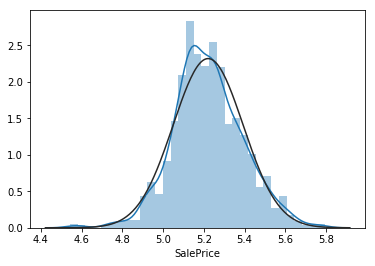

In [43]:
hp['SalePrice'] = np.log10(hp['SalePrice'])

sns.distplot(hp['SalePrice'], fit=stats.norm)

This looks much better. Now I have to remember to convert the predictions before handling them in. :)  
  
**Correlation**  
Now I want to see the numeric values that shows a correlation higher than 0,5.

In [44]:
corr_hp = hp.select_dtypes(include=[np.number]).corr()

In [45]:
corr_hp.index[abs((corr_hp['SalePrice']<-0.5))]

Index([], dtype='object')

In [46]:
corr_hp.index[abs((corr_hp['SalePrice']>0.5))]

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual',
       'TotRmsAbvGrd', 'FireplaceQu', 'GarageFinish', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

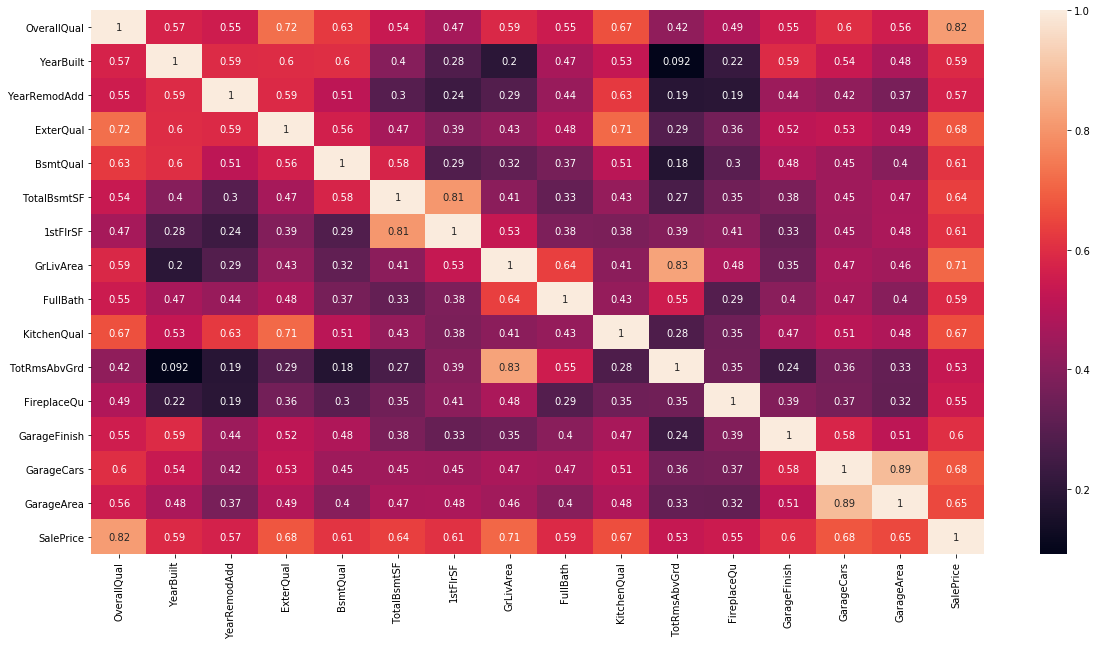

In [47]:
top_corr = hp[corr_hp.index[abs((corr_hp['SalePrice']>0.5))]].corr()
plt.subplots(figsize=(20,10))
sns.heatmap(top_corr, annot=True)
plt.show()

I can see that Overall Qual has a 0,82 correlation and that it would make a good baseline. I can also see that most of the features with high correlation has to do with quality.

In [48]:
hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 75 columns):
MSSubClass       1456 non-null int64
MSZoning         1456 non-null object
LotFrontage      1456 non-null float64
LotArea          1456 non-null int64
Street           1456 non-null object
LotShape         1456 non-null int64
LandContour      1456 non-null object
Utilities        1456 non-null int64
LotConfig        1456 non-null object
LandSlope        1456 non-null int64
Neighborhood     1456 non-null object
Condition1       1456 non-null object
Condition2       1456 non-null object
BldgType         1456 non-null object
HouseStyle       1456 non-null object
OverallQual      1456 non-null int64
OverallCond      1456 non-null int64
YearBuilt        1456 non-null int64
YearRemodAdd     1456 non-null int64
RoofStyle        1456 non-null object
RoofMatl         1456 non-null object
Exterior1st      1456 non-null object
Exterior2nd      1456 non-null object
MasVnrType       1456 non-n

**Test data**  
Now I just have to take the exact same steps with the test data as with the train data - except for the Sales price as that is what we are predicting. 

In [49]:
testhp=pd.read_csv('test.csv')

In [50]:
#To have the original csv to check that the predictions are paired with the right Id.
testhp_w_Id = testhp.copy()

I'll start by deleting all the columns that I deleted from the train data set. 

In [51]:
testhp.drop(['Id', 'PoolQC','MiscFeature', 'Alley', 'Fence', 'GarageYrBlt'],axis=1,inplace=True)

In [52]:
testhp.shape

(1459, 74)

Looking at the shape I see that I have removed all the columns that I took away. The test data also lacks the column price since that's what I am trying to predict, this is why the shape states the same number of columns as the "hp".  
  
I'll look at the info to see if there's missing data in other columns than the train data. 

In [53]:
nulltest = testhp.isnull().sum()/len(hp)*100
nulltest = nulltest[nulltest>0]
nulltest.sort_values(inplace=True, ascending=False)
nulltest = nulltest.to_frame()
nulltest.columns=['Count']
nulltest.index.names = ['Column']
nulltest.reset_index(level=0, inplace=True)
nulltest

,Column,Count
0,FireplaceQu,50.137363
1,LotFrontage,15.590659
2,GarageQual,5.357143
3,GarageFinish,5.357143
4,GarageCond,5.357143
5,GarageType,5.219780
6,BsmtCond,3.090659
7,BsmtExposure,3.021978
8,BsmtQual,3.021978
9,BsmtFinType1,2.884615


I will handle the missing value column by column the same way I did with the train data set. 

In [54]:
testhp.update(testhp[['GarageCond','GarageFinish','GarageQual', 'GarageType', 'FireplaceQu', 
             'BsmtCond','BsmtExposure','BsmtQual', 'BsmtFinType1', 'BsmtFinType2']].fillna('N'))
testhp.update(testhp[['LotFrontage', 'MasVnrArea', 'BsmtFullBath', 'Functional', 'BsmtHalfBath',
                     'Exterior2nd', 'Exterior1st', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
                     'GarageArea', 'BsmtFinSF2', 'GarageCars']].fillna(0))
testhp['MasVnrType'].fillna('None', inplace = True)
testhp['SaleType']= testhp['SaleType'].fillna(hp['SaleType'].mode()[0])
testhp['KitchenQual']= testhp['KitchenQual'].fillna(hp['KitchenQual'].mode()[0])
testhp['MSZoning']= testhp['MSZoning'].fillna(hp['MSZoning'].mode()[0])

In [55]:
testhp['Utilities'].fillna('AllPub', inplace = True)
testhp['Functional'].fillna('Typ', inplace = True)

Now I'll go on to change the ordinal categorical values to numerical values, just as I did on the train data set. 

In [56]:
testhp['LotShape'] = testhp['LotShape'].map({'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3})
testhp['Utilities'] = testhp['Utilities'].map({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1})
testhp['LandSlope'] = testhp['LandSlope'].map({'Gtl': 1, 'Mod': 2, 'Sev': 3})
testhp[['ExterCond','ExterQual','HeatingQC', 'KitchenQual']] = testhp[
    ['ExterCond','ExterQual','HeatingQC', 'KitchenQual']].applymap(n.get)
testhp[['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']] = testhp[
    ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']].applymap(b.get)
testhp[['BsmtFinType1', 'BsmtFinType2']] = testhp[['BsmtFinType1', 'BsmtFinType2']].applymap(bt.get)
testhp['Functional'] = testhp['Functional'].map({
    'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7})
testhp['BsmtExposure'] = testhp['BsmtExposure'].map({'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0, 'N':0})
testhp['GarageFinish'] = testhp['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'N': 0})
testhp['PavedDrive'] = testhp['PavedDrive'].map({'Y': 2, 'P': 1, 'N': 0})
testhp['CentralAir'] = testhp['CentralAir'].map({'Y': 1, 'N': 0})

In [57]:
testhp.columns[testhp.isna().any()].tolist()

['KitchenQual', 'Functional']

Somehow I still have missing values in Functional, and KitchenQual, but strangely enough, if I run the cell with their fillna twice it is fixed. So for now I just do that. 

In [58]:
testhp['Functional'].fillna(0, inplace = True)
testhp['KitchenQual']= testhp['KitchenQual'].fillna(hp['KitchenQual'].mode()[0])

In [59]:
testhp.columns[testhp.isna().any()].tolist()

[]

I now create a new data frame with the both data sets. This way I can create new features and get all the columns in both data sets when I do the one-hot encoding. 

In [61]:
ohenchp=pd.concat([hp,testhp],axis=0, sort=True)

I decide to make a feature called 'BldPeriod', representing the building periods in which the houses were built (roughly). 

+ Before 1925; 1
+ 1926 to 1960; 2
+ 1961 to 1986; 3
+ 1987 to 1999; 4
+ Later than 2000; 5

In [62]:
bins= [0,1925,1960,1986,1999,2020]
labels = [1,2,3,4,5]
ohenchp['BldPeriod'] = pd.cut(ohenchp['YearBuilt'], bins=bins, labels=labels, right=False)

In [63]:
ohenchp.shape

(2915, 76)

I create a variable where I store all the columns I want to one-hot-encode. 

In [64]:
nomcols = ['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 
           'Condition2', 'BldgType', 'BldPeriod', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
           'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType',
           'SaleCondition']

Now I will do the one-hot-encoding. 

In [65]:
ohenchp = pd.get_dummies(ohenchp, columns=nomcols, prefix='', prefix_sep='', drop_first=True)

In [66]:
ohenchp.shape

(2915, 213)

Since I know that the last 1459 of the data inputs are the ones from the test data set I split "ohenchp" to get the train data and test data in seperate data frames again. 

In [67]:
dhp=ohenchp.iloc[:1456,:]
dtesthp=ohenchp.iloc[1456:,:]

In [68]:
dtesthp = dtesthp.drop(['SalePrice'], axis = 1)

In [69]:
dtesthp.shape

(1459, 212)

#### Model fitting and making predictions   
  
I will start by creating a baseline with the column 'OverallQual' that has the highest correlation, using linear regression.

In [70]:
x =dhp['OverallQual'].values.reshape(-1,1)
y = dhp['SalePrice']

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=0)

I need to define the MAE - mean absolute error - to be able to evaluate my results. 

In [71]:
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [72]:
lr = LinearRegression()
lr.fit(x_tr, y_tr)
y_pred_baselilne=lr.predict(x_te)
mae_baseline = MAE(10**y_te, 10**y_pred_baselilne)
print('MAE for my baseline - "OverallQual": {:.3f}'.format(mae_baseline))

MAE for my baseline - "OverallQual": 30508.194


**Regularisation**  
I will do a grid search as to find the best values to later do a ridgeregression. I will use all the variables in this "complex" model. 

In [73]:
X = dhp.drop(columns =['SalePrice'])
y = dhp['SalePrice']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=0)

In [74]:
gs_results = []


for alpha in np.logspace(-10, 10, num=100):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_tr, ridge.predict(X_tr)),
        'train_mae': MAE(10**y_tr, 10**ridge.predict(X_tr)),
        'test_mse': MSE(y_te, ridge.predict(X_te)),
        'test_mae': MAE(10**y_te, 10**ridge.predict(X_te)),
    })

I create a data frame of the saved results and plot them to get an overview

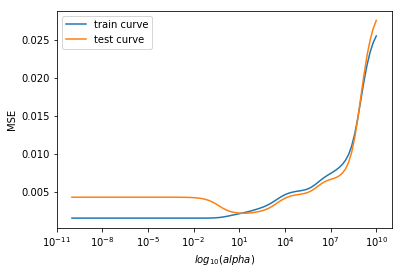

In [75]:
gs_results = pd.DataFrame(gs_results)

# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mse'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mse'], label='test curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

I then fit a model with a strong regularisation.

In [76]:
strong_ridge = Ridge(alpha=10**2)
strong_ridge.fit(X_tr, y_tr)

print('Largest coefficient: {:.1e}'.format(
    np.max(np.abs(strong_ridge.coef_)))) 
print('Intercept: {:.2f}'.format(
    strong_ridge.intercept_)) 

Largest coefficient: 2.4e-02
Intercept: 6.31


Then I get the best result regarding mean squered error. 

In [77]:
# Get entry with the best test MSE
best_result = gs_results.loc[gs_results.test_mse.idxmin()]

#Saving best alpha
best_alpha = best_result.alpha

# Print the details
print('Best alpha: {:.1e}'.format(best_result.alpha)) 
print('Test MSE: {:.4f}'.format(best_result.test_mse)) 
print('Test MAE: {:,.0f}$'.format(best_result.test_mae)) 

Best alpha: 2.1e+01
Test MSE: 0.0022
Test MAE: 14,806$


Then I fit a model with the best alpha.

In [78]:
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_tr, y_tr) 

Ridge(alpha=20.565123083486515, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [79]:
mae_r = MAE(10**y_te, 10**(best_ridge.predict(X_te)))
print('MAE for my complex model using ridge regression: {:.3f}'.format(mae_r))

MAE for my complex model using ridge regression: 14805.920


Now I use this model at my test data to make predictions on that to submit to the Kaggle competition. 

In [80]:
X_test= dtesthp.values
predictions = 10**(best_ridge.predict(X_test))

In [85]:
cplx_pred = pd.DataFrame(predictions)
cplx_pred.columns=['SalePrice']
complx_pred=pd.concat([testhp_w_Id['Id'], cplx_pred], axis = 1) 
complx_pred.to_csv('mactilda-predictions.csv', index=False)

I am now ready to submit my predictions. 